In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import log_loss  


In [2]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9618 entries, 0 to 9617
Data columns (total 39 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   ID                                                                9618 non-null   object 
 1   country                                                           9618 non-null   object 
 2   owner_age                                                         9618 non-null   float64
 3   attitude_stable_business_environment                              9616 non-null   object 
 4   attitude_worried_shutdown                                         9616 non-null   object 
 5   compliance_income_tax                                             9614 non-null   object 
 6   perception_insurance_doesnt_cover_losses                          9613 non-null   object 
 7   perception_cannot_afford_insuranc

In [4]:
#drop ID column in train and test data
train_data.drop('ID', axis=1)
test_data.drop('ID', axis=1)

,country,owner_age,attitude_stable_business_environment,attitude_worried_shutdown,compliance_income_tax,perception_insurance_doesnt_cover_losses,perception_cannot_afford_insurance,personal_income,business_expenses,business_turnover,...,has_loan_account,has_internet_banking,has_debit_card,future_risk_theft_stock,business_age_months,medical_insurance,funeral_insurance,motivation_make_more_money,uses_friends_family_savings,uses_informal_lender
0,zimbabwe,50.0,No,No,No,No,Yes,100.0,3600.0,7200.0,...,NaN,NaN,NaN,No,8.0,Never had,Never had,NaN,NaN,NaN
1,lesotho,36.0,Yes,Yes,No,Yes,Yes,900.0,400.0,900.0,...,NaN,NaN,NaN,Yes,NaN,NaN,NaN,Yes,Used to have but don't have now,Used to have but don't have now
2,lesotho,25.0,Don’t know or N/A,No,No,Don't know,Don't know,5250.0,350.0,1000.0,...,Used to have but don't have now,Have now,Have now,Yes,NaN,NaN,NaN,No,Never had,Used to have but don't have now
3,malawi,25.0,Don’t know or N/A,Yes,No,No,Yes,485000.0,10000.0,20000.0,...,Never had,Never had,Never had,Yes,NaN,NaN,NaN,Yes,Have now,Never had
4,lesotho,47.0,No,Yes,No,Don't know,Don't know,97.0,500.0,2000.0,...,Used to have but don't have now,Have now,Have now,Yes,NaN,NaN,NaN,Yes,Used to have but don't have now,Used to have but don't have now
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400,eswatini,29.0,Yes,Yes,No,No,Yes,600.0,1700.0,2000.0,...,Never had,Never had,Never had,NaN,11.0,Never had,Never had,NaN,Never had,Never had
2401,malawi,20.0,Don’t know or N/A,Don’t know or N/A,No,Don't know,Don't know,30000.0,20000.0,25000.0,...,Never had,Never had,Never had,No,4.0,NaN,NaN,Yes,NaN,NaN
2402,zimbabwe,26.0,Yes,Yes,No,Yes,Yes,3888.0,NaN,NaN,...,NaN,NaN,NaN,No,0.0,Have now,Have now,NaN,NaN,NaN
2403,eswatini,63.0,No,No,Yes,Yes,Yes,3500.0,1700.0,1200.0,...,Never had,Never had,Never had,NaN,4.0,Never had,Have now,NaN,Never had,Never had


Feature Engineering

In [91]:


# Assuming your data is in df
train_data['business_age_years'] = train_data['business_age_years'].astype(float)
train_data['business_age_months'] = train_data['business_age_months'].astype(float)

# Correlation with turnover
corr_years = train_data['business_age_years'].corr(train_data['business_turnover'])
corr_months = train_data['business_age_months'].corr(train_data['business_turnover'])

print("Correlation (years) vs turnover:", corr_years)
print("Correlation (months) vs turnover:", corr_months)


Correlation (years) vs turnover: 0.0434147738244143
Correlation (months) vs turnover: 0.052139015065862535


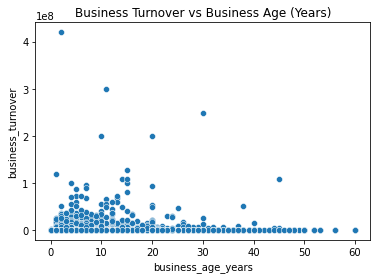

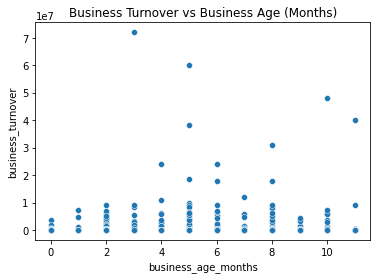

In [92]:

sns.scatterplot(x='business_age_years', y='business_turnover', data=train_data)
plt.title('Business Turnover vs Business Age (Years)')
plt.show()

sns.scatterplot(x='business_age_months', y='business_turnover', data=train_data)
plt.title('Business Turnover vs Business Age (Months)')
plt.show()

In [111]:
train_data['owner_age'].describe()

count    9618.000000
mean       41.705344
std        13.314010
min        18.000000
25%        32.000000
50%        40.000000
75%        50.000000
max       103.000000
Name: owner_age, dtype: float64


FEATURE ENGINEERING - GETTING STARTED

💡 Let's create some new features to boost your model performance!

We'll demonstrate 2 powerful feature engineering techniques:

1️⃣ PROFIT MARGIN RATIO
----------------------------------------
Concept: How much profit does the business make relative to income?
Formula: (personal_income - business_expenses) / personal_income

✓ Created 'profit_margin' feature
  Train - Non-null values: 9338
  Test - Non-null values: 2322

Sample statistics:
count    9338.000000
mean       -0.200178
std         0.796198
min        -1.000000
25%        -1.000000
50%        -0.285714
75%         0.600000
max         1.000000
Name: profit_margin, dtype: float64

📊 Profit Margin by Target:
            mean    median       std
Target                              
High   -0.278023 -0.500000  0.762552
Low    -0.193241 -0.250000  0.800371
Medium -0.202494 -0.333333  0.792035


<Figure size 720x360 with 0 Axes>

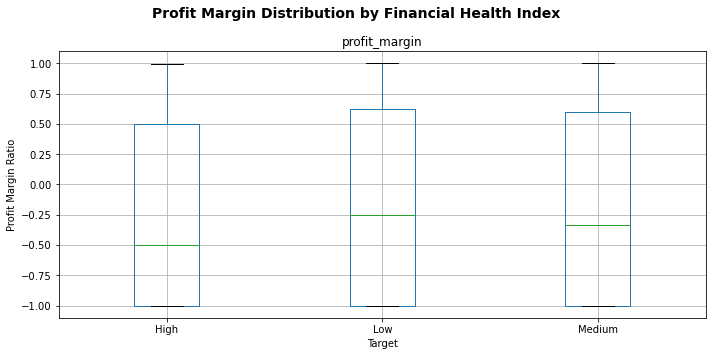


2️⃣ FINANCIAL ACCESS SCORE
----------------------------------------
Concept: How many formal financial services does the business use?
Includes: bank accounts, debit cards, internet banking, loans, insurance

✓ Created 'financial_access_score' feature
  Train - Non-null values: 8228
  Test - Non-null values: 2066

Sample statistics:
count    8228.000000
mean        0.189297
std         0.276240
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: financial_access_score, dtype: float64

📊 Financial Access Score by Target:
            mean    median       std
Target                              
High    0.490086  0.400000  0.248168
Low     0.091164  0.000000  0.208255
Medium  0.372129  0.333333  0.292329


<Figure size 720x360 with 0 Axes>

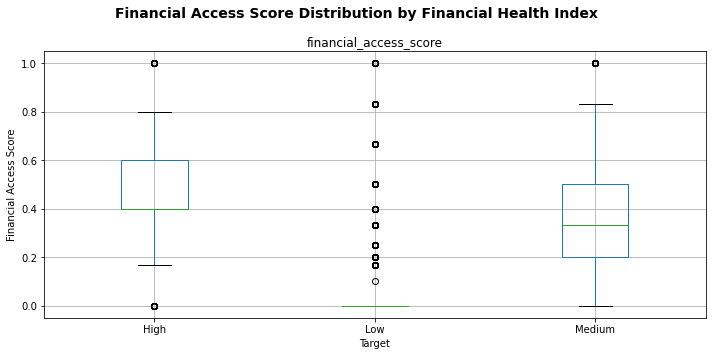


FEATURE ENGINEERING SUMMARY

✅ Successfully created 2 new features:

1. profit_margin:
   - Measures business profitability
   - Higher values = better financial performance
   - Useful for identifying financially healthy businesses

2. financial_access_score:
   - Measures access to formal financial services
   - Range: 0 (no access) to 1 (full access)
   - Reflects financial inclusion level

💡 MORE FEATURE IDEAS TO TRY:
   • Age bins (categorize owner_age into groups)
   • Income-to-expenses ratio
   • Business maturity (young vs established)
   • Risk perception score (combine attitude columns)
   • Country-specific features (encode regional patterns)
   • Insurance coverage index
   • Digital banking adoption flag

📝 NEXT STEPS:
   1. Add these features to your modeling pipeline
   2. Check feature importance after training
   3. Create more domain-specific features
   4. Test interaction features between variables
   5. Experiment with polynomial features for numerical data

🎯 Re

In [5]:
# ========================================
# 12. FEATURE ENGINEERING
# ========================================

print("\n" + "=" * 60)
print("FEATURE ENGINEERING - GETTING STARTED")
print("=" * 60)

print("\n💡 Let's create some new features to boost your model performance!")
print("\nWe'll demonstrate 2 powerful feature engineering techniques:")

# Create copies to preserve original data
train_fe = train_data.copy()
test_fe = test_data.copy()

# ----------------------------------------
# Feature 1: Profit Margin Ratio
# ----------------------------------------
print("\n1️⃣ PROFIT MARGIN RATIO")
print("-" * 40)
print("Concept: How much profit does the business make relative to income?")
print("Formula: (personal_income - business_expenses) / personal_income")

def create_profit_margin(df):
    """
    Calculate profit margin ratio for each business.
    This indicates financial efficiency and sustainability.
    """
    # Handle division by zero and missing values
    profit_margin = []
    
    for idx, row in df.iterrows():
        income = row.get('personal_income', np.nan)
        expenses = row.get('business_expenses', np.nan)
        
        # Check if both values exist and income is not zero
        if pd.notna(income) and pd.notna(expenses) and income != 0:
            margin = (income - expenses) / income
            # Cap extreme values
            margin = max(-1, min(margin, 1))  # Keep between -1 and 1
        else:
            margin = np.nan
        
        profit_margin.append(margin)
    
    return profit_margin

train_fe['profit_margin'] = create_profit_margin(train_fe)
test_fe['profit_margin'] = create_profit_margin(test_fe)

print(f"\n✓ Created 'profit_margin' feature")
print(f"  Train - Non-null values: {train_fe['profit_margin'].notna().sum()}")
print(f"  Test - Non-null values: {test_fe['profit_margin'].notna().sum()}")
print("\nSample statistics:")
print(train_fe['profit_margin'].describe())

# Show relationship with target
if 'Target' in train_fe.columns:
    print("\n📊 Profit Margin by Target:")
    print(train_fe.groupby('Target')['profit_margin'].agg(['mean', 'median', 'std']))
    
    # Visualize
    plt.figure(figsize=(10, 5))
    train_fe.boxplot(column='profit_margin', by='Target', figsize=(10, 5))
    plt.suptitle('Profit Margin Distribution by Financial Health Index', 
                 fontsize=14, fontweight='bold')
    plt.xlabel('Target')
    plt.ylabel('Profit Margin Ratio')
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# Feature 2: Financial Access Score
# ----------------------------------------
print("\n2️⃣ FINANCIAL ACCESS SCORE")
print("-" * 40)
print("Concept: How many formal financial services does the business use?")
print("Includes: bank accounts, debit cards, internet banking, loans, insurance")

def create_financial_access_score(df):
    """
    Calculate a composite score of financial service access.
    Higher score = better access to formal financial services.
    """
    financial_features = [
        'has_bank_account', 'has_loan_account', 'has_internet_banking',
        'has_debit_card', 'medical_insurance', 'funeral_insurance'
    ]
    
    # Available features in the dataset
    available_features = [col for col in financial_features if col in df.columns]
    
    scores = []
    for idx, row in df.iterrows():
        score = 0
        valid_features = 0
        
        for feature in available_features:
            value = row.get(feature, np.nan)
            
            if pd.notna(value):
                valid_features += 1
                # Check for positive responses
                if value in ['Yes', 'Have now', 'have now']:
                    score += 1
                elif value in ['Used to have but don\'t have now', 'used to have']:
                    score += 0.5  # Partial credit for past access
        
        # Normalize by number of valid features checked
        if valid_features > 0:
            normalized_score = score / valid_features
        else:
            normalized_score = np.nan
        
        scores.append(normalized_score)
    
    return scores

train_fe['financial_access_score'] = create_financial_access_score(train_fe)
test_fe['financial_access_score'] = create_financial_access_score(test_fe)

print(f"\n✓ Created 'financial_access_score' feature")
print(f"  Train - Non-null values: {train_fe['financial_access_score'].notna().sum()}")
print(f"  Test - Non-null values: {test_fe['financial_access_score'].notna().sum()}")
print("\nSample statistics:")
print(train_fe['financial_access_score'].describe())

# Show relationship with target
if 'Target' in train_fe.columns:
    print("\n📊 Financial Access Score by Target:")
    print(train_fe.groupby('Target')['financial_access_score'].agg(['mean', 'median', 'std']))
    
    # Visualize
    plt.figure(figsize=(10, 5))
    train_fe.boxplot(column='financial_access_score', by='Target', figsize=(10, 5))
    plt.suptitle('Financial Access Score Distribution by Financial Health Index', 
                 fontsize=14, fontweight='bold')
    plt.xlabel('Target')
    plt.ylabel('Financial Access Score')
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# Summary
# ----------------------------------------
print("\n" + "=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)

print("\n✅ Successfully created 2 new features:")
print("\n1. profit_margin:")
print("   - Measures business profitability")
print("   - Higher values = better financial performance")
print("   - Useful for identifying financially healthy businesses")

print("\n2. financial_access_score:")
print("   - Measures access to formal financial services")
print("   - Range: 0 (no access) to 1 (full access)")
print("   - Reflects financial inclusion level")

print("\n💡 MORE FEATURE IDEAS TO TRY:")
print("   • Age bins (categorize owner_age into groups)")
print("   • Income-to-expenses ratio")
print("   • Business maturity (young vs established)")
print("   • Risk perception score (combine attitude columns)")
print("   • Country-specific features (encode regional patterns)")
print("   • Insurance coverage index")
print("   • Digital banking adoption flag")

print("\n📝 NEXT STEPS:")
print("   1. Add these features to your modeling pipeline")
print("   2. Check feature importance after training")
print("   3. Create more domain-specific features")
print("   4. Test interaction features between variables")
print("   5. Experiment with polynomial features for numerical data")

print("\n🎯 Remember: Good features can make a bigger difference than complex models!")

# Save engineered datasets (optional)
print("\n💾 Your engineered dataframes are ready:")
print(f"   • train_fe: {train_fe.shape}")
print(f"   • test_fe: {test_fe.shape}")

print("\n" + "=" * 60)

In [6]:
# Create one consolidated feature
# We use (age - 17) because most business activity starts after 18.
# This makes the "experience" more accurate.

train_fe['turnover_age_efficiency'] = train_fe['business_turnover'] / (train_fe['owner_age'] - 17)
test_fe['turnover_age_efficiency'] = test_fe['business_turnover'] / (test_fe['owner_age'] - 17)

# Handle cases where age was under 18 or missing
train_fe['turnover_age_efficiency'] = train_fe['turnover_age_efficiency'].fillna(0).replace([np.inf, -np.inf], 0)
test_fe['turnover_age_efficiency'] = test_fe['turnover_age_efficiency'].fillna(0).replace([np.inf, -np.inf], 0)

print("✓ Created 'turnover_age_efficiency' as the primary consolidated feature.")

✓ Created 'turnover_age_efficiency' as the primary consolidated feature.


In [7]:
train_fe.columns

Index(['ID', 'country', 'owner_age', 'attitude_stable_business_environment',
       'attitude_worried_shutdown', 'compliance_income_tax',
       'perception_insurance_doesnt_cover_losses',
       'perception_cannot_afford_insurance', 'personal_income',
       'business_expenses', 'business_turnover', 'business_age_years',
       'motor_vehicle_insurance', 'has_mobile_money',
       'current_problem_cash_flow', 'has_cellphone', 'owner_sex',
       'offers_credit_to_customers', 'attitude_satisfied_with_achievement',
       'has_credit_card', 'keeps_financial_records',
       'perception_insurance_companies_dont_insure_businesses_like_yours',
       'perception_insurance_important', 'has_insurance',
       'covid_essential_service', 'attitude_more_successful_next_year',
       'problem_sourcing_money', 'marketing_word_of_mouth', 'has_loan_account',
       'has_internet_banking', 'has_debit_card', 'future_risk_theft_stock',
       'business_age_months', 'medical_insurance', 'funeral_insura

Feature Selection

In [8]:
# Define x and y 
X = train_fe.drop(columns=['Target', 'ID'])
y = train_fe['Target']



X_test = test_fe.drop(columns=['ID'])

In [9]:
def change_object_to_cat(df):
  # changes objects columns to category and returns dataframe and list

  df = df.copy()
  list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
  for str_obj_col in list_str_obj_cols:
      df[str_obj_col] = df[str_obj_col].astype("category")

  return df,list_str_obj_cols
X, cat_list = change_object_to_cat(X)

X

,country,owner_age,attitude_stable_business_environment,attitude_worried_shutdown,compliance_income_tax,perception_insurance_doesnt_cover_losses,perception_cannot_afford_insurance,personal_income,business_expenses,business_turnover,...,future_risk_theft_stock,business_age_months,medical_insurance,funeral_insurance,motivation_make_more_money,uses_friends_family_savings,uses_informal_lender,profit_margin,financial_access_score,turnover_age_efficiency
0,eswatini,63.0,Yes,No,No,No,Yes,3000.0,6000.0,7000.0,...,NaN,6.0,Never had,Used to have but don’t have now,NaN,Never had,Never had,-1.000000,0.000000,1.521739e+02
1,zimbabwe,39.0,No,Yes,Yes,No,Yes,NaN,NaN,NaN,...,No,3.0,Never had,Never had,NaN,NaN,NaN,NaN,0.000000,0.000000e+00
2,malawi,34.0,Don’t know or N/A,No,No,Don't know,Yes,30000.0,6000.0,13000.0,...,Yes,NaN,NaN,NaN,Yes,NaN,NaN,0.800000,0.000000,7.647059e+02
3,malawi,28.0,Yes,No,No,No,No,180000.0,60000.0,30000.0,...,No,NaN,NaN,NaN,Yes,Never had,Have now,0.666667,0.000000,2.727273e+03
4,zimbabwe,43.0,Yes,No,No,Yes,Yes,50.0,2400.0,1800.0,...,No,0.0,Never had,Never had,Yes,NaN,NaN,-1.000000,0.000000,6.923077e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9613,lesotho,31.0,Yes,No,No,Don't know,Don't know,2000.0,800.0,500.0,...,NaN,NaN,NaN,NaN,No,Have now,Never had,0.600000,NaN,3.571429e+01
9614,malawi,64.0,Don’t know or N/A,Don’t know or N/A,Yes,No,No,10000000.0,5000000.0,200000000.0,...,Yes,NaN,NaN,NaN,No,NaN,NaN,0.500000,0.333333,4.255319e+06
9615,zimbabwe,43.0,Yes,No,No,Yes,No,450.0,NaN,NaN,...,No,8.0,Have now,Have now,NaN,NaN,NaN,NaN,1.000000,0.000000e+00
9616,zimbabwe,38.0,Yes,Yes,No,No,Yes,2000.0,NaN,NaN,...,No,0.0,Never had,Never had,NaN,NaN,NaN,NaN,0.000000,0.000000e+00


In [10]:
# 1. Identify your columns
num_cols = X.select_dtypes(include=['float64']).columns
cat_cols = X.select_dtypes(include=['category']).columns

# 2. Define the Numerical Transformer
# Median is safer for financial data; Scaling is essential for most models
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Define the Categorical Transformer
# handle_unknown='ignore' prevents the model from crashing if the test set 
# has a category the training set never saw.
# Updated for older Scikit-Learn versions
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output =False))
])

# 4. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)


print(f"Original shape: {X.shape}")


Original shape: (9618, 40)


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
# pipelines

#logistic regression
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),('model', LogisticRegression(C=1.0, solver= 'saga' ,max_iter=5000, random_state=42, class_weight='balanced', multi_class= 'multinomial', l1_ratio= 1,penalty= 'elasticnet'))
])

# decision tree classifier
dec_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),('model', DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced'))
])  

# random forest classifier
rand_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),('model', RandomForestClassifier(n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
))
])  

In [ ]:
#cross-validation with log loss
# stratified-k-folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# creating a model dictionary
models = {
    'Logistic Regression': log_reg,
    'Decision Tree': dec_tree,
    'Random Forest': rand_forest
}

results = []

for name, model in models.items():
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')
    roc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc_ovr')


    results.append({
        'Model': name,
        'Accuracy': acc.mean(),
        'F1 Score': f1.mean(),
        'ROC AUC': roc.mean()
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  F1 Score   ROC AUC
0  Logistic Regression  0.817118  0.731274  0.928315
1        Decision Tree  0.820548  0.733015  0.909632
2        Random Forest  0.869205  0.804544  0.948220


In [103]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=train_fe[['country', 'Target']]
)

In [104]:
from sklearn.metrics import f1_score

models = {
    "Logistic Regression": log_reg,
    "Decision Tree": dec_tree,
    "Random Forest": rand_forest
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"{name} F1 Macro: {f1:.4f}")



Logistic Regression F1 Macro: 0.7221
Decision Tree F1 Macro: 0.7476
Random Forest F1 Macro: 0.8112


In [ ]:
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    scores = cross_val_score(model, X, y,
                             cv=10,
                             scoring='f1_macro')
    print(f"{name} CV F1 Macro: {scores.mean():.4f}")


Logistic Regression CV F1 Macro: 0.7303
Decision Tree CV F1 Macro: 0.7325
Random Forest CV F1 Macro: 0.8060


In [ ]:
best_model = rand_forest  

best_model.fit(X, y)  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['owner_age', 'personal_income', 'business_expenses',
       'business_turnover', 'business_age_years', 'business_age_months',
       'profit_margin', 'financial_access_score'],
      dtype='object')),
                                                 ('cat',
                                                  Pi...
       'problem_sourcing_money', 'marketing_word_of_mouth', 'has_loan_account',
       'has_internet_banking', 'has_debit_card', 'future_risk_theft_stock',
       'medical_insurance', 'funeral_insurance', 'motivation_make_more_money',
       'uses_friends_family_savings', 'uses_informal_lender'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=300, random_state=42))])

In [37]:
test_preds = best_model.predict(X_test)
test_preds

array(['Low', 'Low', 'Low', ..., 'Medium', 'Medium', 'Low'], dtype=object)

In [39]:
pred_df4 = pd.DataFrame({
    "ID": test_fe["ID"],
    "Target": test_preds
})

pred_df4.to_csv("submission5.csv", index=False)


In [40]:
pred_df4

,ID,Target
0,ID_5EGLKX,Low
1,ID_4AI7RE,Low
2,ID_V9OB3M,Low
3,ID_6OI9DI,Low
4,ID_H2TN8B,Low
...,...,...
2400,ID_FX7XJZ,Low
2401,ID_XAL1LX,Low
2402,ID_UHBP0F,Medium
2403,ID_GKIKR2,Medium


### Tune hyperparameter

In [43]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))  # ✅ instance
])


In [44]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'model__n_estimators': [200, 300, 500],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__class_weight': ['balanced']
}


search = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',
    cv=5,
    n_iter=20,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)
print(search.best_score_)
print(search.best_params_)


0.8066981409369578
{'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None, 'model__class_weight': 'balanced'}


In [46]:
# The best pipeline after RandomizedSearchCV
best_pipeline = search.best_estimator_

# Predict class labels on test data
y_test_pred = best_pipeline.predict(X_test)

y_test_pred

array(['Low', 'Low', 'Low', ..., 'Medium', 'Medium', 'Low'], dtype=object)

In [47]:
pred_df5 = pd.DataFrame({
    "ID": test_fe["ID"],
    "Target": test_preds
})

pred_df5.to_csv("submission6.csv", index=False)

In [48]:
pred_df5

,ID,Target
0,ID_5EGLKX,Low
1,ID_4AI7RE,Low
2,ID_V9OB3M,Low
3,ID_6OI9DI,Low
4,ID_H2TN8B,Low
...,...,...
2400,ID_FX7XJZ,Low
2401,ID_XAL1LX,Low
2402,ID_UHBP0F,Medium
2403,ID_GKIKR2,Medium


In [14]:
from xgboost import XGBClassifier


In [15]:
xgb= XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)


In [16]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [17]:
# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'High','Low','Medium' -> 0,1,2 (or in sorted order)



In [18]:


# Identify categorical and numeric columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['category']).columns



preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, ), cat_cols)
    ]
)

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        random_state=42
    ))
])

xgb_pipeline.fit(X, y_encoded)

y_pred = xgb_pipeline.predict(X_test)




In [19]:
# Split first
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Encode AFTER splitting
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)


In [20]:
xgb_pipeline.fit(X_train, y_train_encoded)

y_val_pred = xgb_pipeline.predict(X_val)


In [27]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_val_encoded, y_val_pred)
f1 = f1_score(y_val_encoded, y_val_pred, average='macro')

print("Validation Accuracy:", accuracy)
print("Validation F1 (Macro):", f1)


Validation Accuracy: 0.8804573804573804
Validation F1 (Macro): 0.8246477935153361


In [28]:
# Predict class labels on test data
y_test_pred = xgb_pipeline.predict(X_test)

y_test_pred

array([1, 2, 1, ..., 2, 2, 1], dtype=int64)

In [29]:
y_test_pred_labels = le.inverse_transform(y_test_pred)
y_test_pred_labels

array(['Low', 'Medium', 'Low', ..., 'Medium', 'Medium', 'Low'],
      dtype=object)

In [30]:
pred_s = pd.DataFrame({
    "ID": test_fe["ID"],
    "Target": y_test_pred_labels
})

pred_s.to_csv("submission9.csv", index=False)

In [31]:
pred_s

,ID,Target
0,ID_5EGLKX,Low
1,ID_4AI7RE,Medium
2,ID_V9OB3M,Low
3,ID_6OI9DI,Medium
4,ID_H2TN8B,Low
...,...,...
2400,ID_FX7XJZ,Low
2401,ID_XAL1LX,Low
2402,ID_UHBP0F,Medium
2403,ID_GKIKR2,Medium


In [33]:
param_grid = {
    'model__learning_rate': [0.1, 0.2],
    'model__max_depth': [6],
    'model__min_child_weight': [1, 2],
    'model__subsample': [0.5, 0.7],
    'model__n_estimators': [100],
}


In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

grid = GridSearchCV(
    xgb_pipeline,
    param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train_encoded)

print("Best CV F1:", grid.best_score_)
print("Best Params:", grid.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV F1: 0.8088230782029054
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__min_child_weight': 1, 'model__n_estimators': 100, 'model__subsample': 0.7}


In [35]:
best_model1 = grid.best_estimator_

y_val_pred = best_model1.predict(X_val)

from sklearn.metrics import f1_score, accuracy_score

print("Validation Accuracy:", accuracy_score(y_val_encoded, y_val_pred))
print("Validation F1:", f1_score(y_val_encoded, y_val_pred, average='macro'))


Validation Accuracy: 0.8752598752598753
Validation F1: 0.8091785213859929


In [37]:
# Predict class labels on test data
y_test_pred1 = best_model1.predict(X_test)

y_test_pred1

array([1, 1, 1, ..., 2, 2, 1], dtype=int64)

In [38]:
y_test_pred_labels1 = le.inverse_transform(y_test_pred1)
y_test_pred_labels1

array(['Low', 'Low', 'Low', ..., 'Medium', 'Medium', 'Low'], dtype=object)

In [39]:
pred_7 = pd.DataFrame({
    "ID": test_fe["ID"],
    "Target": y_test_pred_labels1
})

pred_7.to_csv("submission10.csv", index=False)

In [40]:
pred_7

,ID,Target
0,ID_5EGLKX,Low
1,ID_4AI7RE,Low
2,ID_V9OB3M,Low
3,ID_6OI9DI,Low
4,ID_H2TN8B,Low
...,...,...
2400,ID_FX7XJZ,Low
2401,ID_XAL1LX,Low
2402,ID_UHBP0F,Medium
2403,ID_GKIKR2,Medium


In [41]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# 4. Train LightGBM
# -------------------------
model = LGBMClassifier()

model.fit(X_train, y_train)

# -------------------------
# 5. Predictions
# -------------------------
y_pred = model.predict(X_val)

# -------------------------
# 6. Evaluation
# -------------------------
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# -------------------------
# 7. Extract top 50 most important features
# -------------------------
feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
})

top50 = feature_importances.sort_values("importance", ascending=False).head(50)
print("\nTop 50 Features:")
print(top50)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 7694, number of used features: 40
[LightGBM] [Info] Start training from score -3.018607
[LightGBM] [Info] Start training from score -0.426214
[LightGBM] [Info] Start training from score -1.210144
Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.61      0.71        94
         Low       0.88      0.97      0.92      1256
      Medium       0.85      0.70      0.76       574

    accuracy                           0.87      1924
   macro avg       0.86      0.76      0.80      1924
weighted avg       0.87      0.87      0.86      1924


Confusion Matrix:
[[  57    6   31]
 [   0 1216   40]
 [  10  165  399]]

Top 50 Features:
                                              feature 

In [42]:
top10_features = feature_importances['feature'].head(10).tolist()
top10_features


['country',
 'owner_age',
 'attitude_stable_business_environment',
 'attitude_worried_shutdown',
 'compliance_income_tax',
 'perception_insurance_doesnt_cover_losses',
 'perception_cannot_afford_insurance',
 'personal_income',
 'business_expenses',
 'business_turnover']

In [43]:

y_labels = le.inverse_transform(y_encoded)

plot_df = X[top10_features].copy()
plot_df['Target'] = y_labels


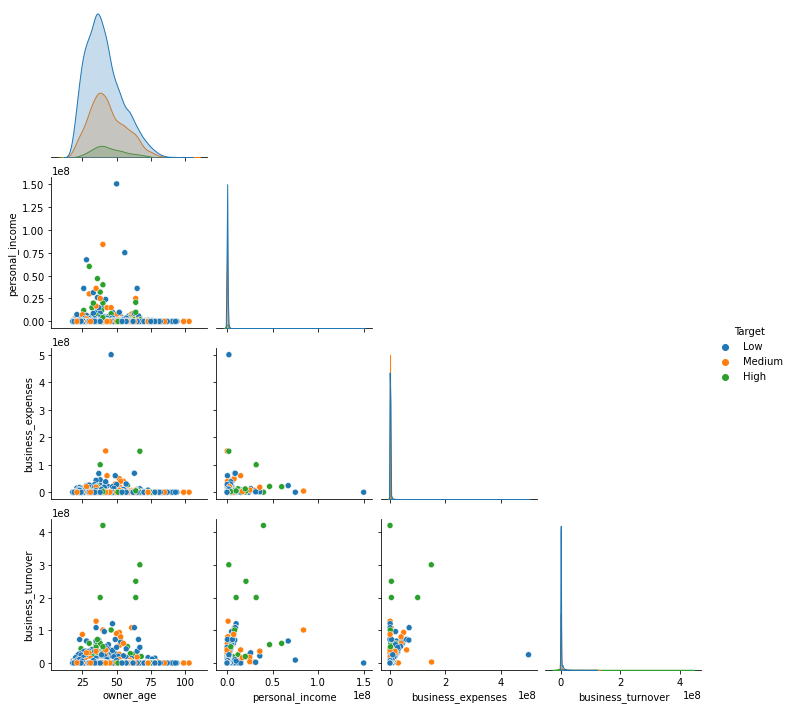

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    plot_df,
    hue='Target',
    diag_kind='kde',  # nicer distributions
    corner=True       # cleaner plot (no duplicate panels)
)

plt.show()
